# Frequent Items

## Initialization
- Load cleaned data and user data with clusters

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import csr_matrix
from mlxtend.frequent_patterns import fpgrowth
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mlxtend.preprocessing import TransactionEncoder
from collections import defaultdict
from itertools import combinations
import networkx as nx
import ast
from sklearn.metrics.pairwise import cosine_similarity
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
file_path_songs = "Data/df_combined.csv"
df_songs = pd.read_csv(file_path_songs)
file_path_clusters = "Data/df_users.csv"
df_users = pd.read_csv(file_path_clusters)

## Compute market basket data frames
- A market basket data frame is computed for each cluster
- Only users with more than 50 total listenings are included
- Each basket includes at most the users 100 most played songs
- Songs which does not occur in more than 10 different baskets are excluded

We generate 11 separate DataFrames stored as `df_basket_1`, `df_basket_2`, ..., `df_basket_11`.

In [82]:
# Calculate the total play count for each user
user_total_playcount = df_users.groupby('user_id')['playcount'].sum().reset_index()
user_total_playcount = user_total_playcount[user_total_playcount['playcount'] >= 50]

# Filter the original user data to include only users with at least 50 total plays
df_users_filtered = df_users[df_users['user_id'].isin(user_total_playcount['user_id'])]

# Process each cluster to generate individual DataFrames
cluster_dataframes = {}  # Dictionary to hold the dataframes for each cluster

for cluster_id in sorted(df_users_filtered['most_played_cluster'].unique()[:11]):  # Ensure max 11 clusters
    # Filter the data for the current cluster
    cluster_data = df_users_filtered[df_users_filtered['most_played_cluster'] == cluster_id]

    # Sort songs for each user by play count and select the 100 most played songs
    def get_top_songs(user_data):
        return user_data.nlargest(100, 'playcount')  # Adjust to desired number of top songs

    # Apply the top song selection for each user
    df_top_songs_cluster = cluster_data.groupby('user_id').apply(get_top_songs).reset_index(drop=True)

    # Create a basket for each user with their top songs
    df_basket_cluster = df_top_songs_cluster.groupby('user_id')['track_id'].apply(list).reset_index()
    df_basket_cluster.rename(columns={'track_id': 'basket'}, inplace=True)

    # Assign the DataFrame to a variable dynamically
    cluster_dataframes[f"df_basket_{cluster_id}"] = df_basket_cluster

    # Optionally, save to a named variable
    globals()[f"df_basket_{cluster_id}"] = df_basket_cluster

In [83]:
# Function to filter songs occurring in more than 10 baskets
def filter_songs(df_basket, min_basket_count=10):
    """
    Filters out songs from the baskets that occur in fewer than `min_basket_count` baskets.
    
    Parameters:
    - df_basket (pd.DataFrame): DataFrame with columns `user_id` and `basket`.
    - min_basket_count (int): Minimum number of baskets a song must appear in to be retained.

    Returns:
    - pd.DataFrame: Filtered DataFrame with updated baskets.
    """
    # Flatten all baskets into a single list to count song occurrences
    all_songs = [song for basket in df_basket['basket'] for song in basket]
    song_counts = Counter(all_songs)

    # Identify songs that occur in more than `min_basket_count` baskets
    frequent_songs = {song for song, count in song_counts.items() if count > min_basket_count}

    # Filter each user's basket to retain only frequent songs
    df_basket['basket'] = df_basket['basket'].apply(lambda basket: [song for song in basket if song in frequent_songs])

    # Remove rows with empty baskets
    df_basket = df_basket[df_basket['basket'].map(len) > 0].reset_index(drop=True)

    return df_basket

# Apply the function to each df_basket_# DataFrame
for cluster_id in cluster_dataframes.keys():
    cluster_dataframes[cluster_id] = filter_songs(cluster_dataframes[cluster_id])

    # Optionally, save back to dynamically created variables
    globals()[cluster_id] = cluster_dataframes[cluster_id]

## Compute association rules and support
- Support and association rules are computed for each basket data frame
- The minimum support used is 2%
- Association rules are computed using the Apriori algorithm to generate frequent single items, dublets, and triplets

In [84]:
# Function to calculate support for itemsets
def calculate_support(data, itemsets):
    itemset_counts = defaultdict(int)
    for basket in data['basket']:
        for itemset in itemsets:
            if set(itemset).issubset(set(basket)):
                itemset_counts[itemset] += 1
    total_baskets = len(data)
    support = {itemset: count / total_baskets for itemset, count in itemset_counts.items()}
    return support

# Apriori Algorithm for Size 2 and 3
def apriori_pairs_and_triplets(data, min_support):
    frequent_itemsets = {}

    # Start with single items
    items = set(item for basket in data['basket'] for item in basket)
    single_itemsets = [(item,) for item in items]
    
    # Calculate support for single items
    support = calculate_support(data, single_itemsets)
    frequent_singles = [itemset for itemset, sup in support.items() if sup >= min_support]
    frequent_itemsets.update({itemset: support[itemset] for itemset in frequent_singles})
    
    print(f"Frequent Single Items: {frequent_singles}")
    
    # Generate pairs (size 2)
    pairs = list(combinations(set(item for itemset in frequent_singles for item in itemset), 2))
    pair_support = calculate_support(data, pairs)
    frequent_pairs = [itemset for itemset, sup in pair_support.items() if sup >= min_support]
    frequent_itemsets.update({itemset: pair_support[itemset] for itemset in frequent_pairs})
    
    print(f"Frequent Pairs: {frequent_pairs}")
    
    # Generate triplets (size 3)
    triplets = list(combinations(set(item for itemset in frequent_pairs for item in itemset), 3))
    triplet_support = calculate_support(data, triplets)
    frequent_triplets = [itemset for itemset, sup in triplet_support.items() if sup >= min_support]
    frequent_itemsets.update({itemset: triplet_support[itemset] for itemset in frequent_triplets})
    
    print(f"Frequent Triplets: {frequent_triplets}")
    
    return frequent_itemsets

## Generate results (freq. items and support)
The frequent items and item sets with corresponding support are stored in a CSV file for each cluster.

In [85]:
# Create a dictionary for all baskets
df_baskets = {f"df_basket_{i}": globals()[f"df_basket_{i}"] for i in range(0, 11)}

min_support = 0.02

# Process each basket and save results
for i, (name, data) in enumerate(df_baskets.items(), start=0):
    print(f"Processing {name}...")
    frequent_itemsets = apriori_pairs_and_triplets(data, min_support)
    
    # Convert frequent itemsets to a DataFrame
    results_df = pd.DataFrame(
        [{"itemset": itemset, "support": support} for itemset, support in frequent_itemsets.items()]
    )
    
    # Save each result DataFrame with a unique name
    output_file = f"Data/Results/cluster_{i}_results.csv"  # Use the index 'i' for unique filenames
    results_df.to_csv(output_file, index=False)
    print(f"Results saved for cluster {i} to {output_file}")

Processing df_basket_0...
Frequent Single Items: [('TRWQINA128F9339E57',), ('TRFTUIW128E0784B9F',), ('TRVQTQG128F93073B0',), ('TRATHTH128F42BC347',), ('TRNXEPE128F9339E47',), ('TRONYHY128F92C9D11',), ('TRBKFKL128E078ED76',), ('TRLRGVX128E078EC1B',), ('TRFXWSD128F93173BF',), ('TRRXGAK128EF349F1A',), ('TRQRMNO128F4235E4D',), ('TRIDQJA12903CE29CC',), ('TRRKGRC128F932D8F0',), ('TRSUSWW128F93463BF',), ('TRDWWGK128F4243516',), ('TRIAGDA128F4296176',), ('TRZALGW128F4296174',), ('TRGOUNV128F4281928',), ('TROWQGL128E0784BAA',), ('TRKFBPS128F429617A',), ('TRFUYPH128F429617B',), ('TRCRCBT128F4260DD1',), ('TROMKCG128F9320C09',), ('TRRRMKC128E0792990',), ('TRVUGOX128E0784629',), ('TRGSVZA128F92CF92E',), ('TRNUMRY12903CB6530',), ('TRCQYJE128E078FA49',), ('TRAFUNV128F92CFEB2',), ('TRILTQH128F93264C4',), ('TRDNHAW128F429DB9A',), ('TRHJOFO12903CBFDE9',), ('TRLIWPE12903CE91C4',), ('TRBVNWT128F93173BA',), ('TRRUZLF128F42396D0',), ('TRUWANM128F1485EE2',), ('TRBFKOV128F426DDF1',), ('TRRXFHO128EF3550BC',), 

## Visualize results: Final songs recommendations
- Heatmap showing the support between pairs of songs (duplets)
- Network graph showing triplets

In [23]:
def process_csv(file_path, id_to_name):
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Parse the 'itemset' column and filter for pairs only
    duplets = {
        tuple(item.strip() for item in ast.literal_eval(row["itemset"])): row["support"]
        for _, row in df.iterrows()
        if len(ast.literal_eval(row["itemset"])) == 2  # Ensure it's a pair
    }

    # Prepare a list of unique track IDs in the duplets
    track_ids = sorted(list(set([item for pair in duplets.keys() for item in pair])))

    # Create a DataFrame for the heatmap
    heatmap_data = pd.DataFrame(0, index=track_ids, columns=track_ids)

    # Populate the DataFrame with support values
    for (track_id1, track_id2), support in duplets.items():
        heatmap_data.loc[track_id1, track_id2] = support
        heatmap_data.loc[track_id2, track_id1] = support  # Ensure symmetry

    # Map track IDs to song names for heatmap labels
    track_id_to_name = {
        track_id: id_to_name.get(track_id, f"Unknown({track_id})")
        for track_id in track_ids
    }
    heatmap_data.rename(index=track_id_to_name, columns=track_id_to_name, inplace=True)

    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        heatmap_data,
        annot=False,
        cmap="Blues",
        cbar_kws={'label': 'Support'}
    )
    #plt.title(f"Song Pair Support Heatmap - {os.path.basename(file_path)}", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save the heatmap
    heatmap_path = os.path.join(output_dir_heatmaps, f"{os.path.basename(file_path).replace('.csv', '')}_heatmap.png")
    plt.savefig(heatmap_path)
    plt.close()
    print(f"Support heatmap saved to {heatmap_path}")

In [24]:
# Directories for input and output
input_dir = "Data/Results"
output_dir_heatmaps = "Data/Heatmaps"
os.makedirs(output_dir_heatmaps, exist_ok=True)

# Define the mapping of track IDs to song names
id_to_name = {
    track_id.strip(): name
    for track_id, name in df_songs.set_index('track_id')['name'].to_dict().items()
}

# Process each CSV file in the input directory
for file_name in os.listdir(input_dir):
    if file_name.endswith(".csv"):  # Process only CSV files
        file_path = os.path.join(input_dir, file_name)
        print(f"Processing {file_name}...")
        process_csv(file_path, id_to_name)

Processing cluster_4_results.csv...
Support heatmap saved to Data/Heatmaps/cluster_4_results_heatmap.png
Processing cluster_8_results.csv...
Support heatmap saved to Data/Heatmaps/cluster_8_results_heatmap.png
Processing cluster_1_results.csv...
Support heatmap saved to Data/Heatmaps/cluster_1_results_heatmap.png
Processing cluster_2_results.csv...
Support heatmap saved to Data/Heatmaps/cluster_2_results_heatmap.png
Processing cluster_7_results.csv...
Support heatmap saved to Data/Heatmaps/cluster_7_results_heatmap.png
Processing cluster_0_results.csv...
Support heatmap saved to Data/Heatmaps/cluster_0_results_heatmap.png
Processing cluster_9_results.csv...
Support heatmap saved to Data/Heatmaps/cluster_9_results_heatmap.png
Processing cluster_10_results.csv...
Support heatmap saved to Data/Heatmaps/cluster_10_results_heatmap.png
Processing cluster_5_results.csv...
Support heatmap saved to Data/Heatmaps/cluster_5_results_heatmap.png
Processing cluster_6_results.csv...
Support heatmap s

In [25]:
def create_graph_from_results(file_path, id_to_name, output_dir_graphs):
    # Load the results file
    df = pd.read_csv(file_path)

    # Parse triplets from the 'itemset' column
    triplets = {
        tuple(item.strip() for item in row["itemset"].strip("()").replace("'", "").split(", ")): row["support"]
        for _, row in df.iterrows()
        if len(row["itemset"].strip("()").split(", ")) == 3  # Ensure only triplets are included
    }

    # Map track IDs to names for triplets
    triplets_with_names = [
        tuple(id_to_name.get(item, f"Unknown({item})") for item in triplet)
        for triplet in triplets.keys()
    ]

    # Create a graph
    G = nx.Graph()

    # Add edges for each triplet
    for triplet in triplets_with_names:
        for pair in combinations(triplet, 2):  # Create edges for all pairs in a triplet
            G.add_edge(pair[0], pair[1])

    # Identify connected components (clusters)
    clusters = [G.subgraph(c).copy() for c in nx.connected_components(G)]

    # Plot and save each cluster
    for i, cluster in enumerate(clusters):
        plt.figure(figsize=(10, 6))
        pos = nx.spring_layout(cluster, seed=42)  # Arrange nodes using spring layout

        # Draw nodes, edges, and labels with updated styles
        nx.draw_networkx_nodes(
            cluster, pos, node_size=300, node_color='skyblue', alpha=0.8
        )  # Smaller nodes
        nx.draw_networkx_edges(
            cluster, pos, width=1, edge_color='gray', alpha=0.6
        )  # Lighter gray edges
        nx.draw_networkx_labels(
            cluster, pos, font_size=12, font_color='black'
        )  # Larger text for labels

        #plt.title(f"Cluster {i + 1} - {os.path.basename(file_path)}", fontsize=16)  # Larger title text
        plt.axis('off')  # Hide axes

        # Save the graph visualization
        graph_path = os.path.join(output_dir_graphs, f"{os.path.basename(file_path).replace('.csv', '')}_cluster_{i + 1}.png")
        plt.savefig(graph_path)
        plt.close()
        print(f"Graph saved for cluster {i + 1} to {graph_path}")

In [26]:
output_dir_graphs = "Data/Graphs"
os.makedirs(output_dir_graphs, exist_ok=True)

# Process each CSV file in the input directory
for file_name in os.listdir(input_dir):
    if file_name.endswith(".csv"):  # Process only CSV files
        file_path = os.path.join(input_dir, file_name)
        print(f"Processing {file_name}...")
        create_graph_from_results(file_path, id_to_name, output_dir_graphs)

Processing cluster_4_results.csv...
Graph saved for cluster 1 to Data/Graphs/cluster_4_results_cluster_1.png
Graph saved for cluster 2 to Data/Graphs/cluster_4_results_cluster_2.png
Graph saved for cluster 3 to Data/Graphs/cluster_4_results_cluster_3.png
Graph saved for cluster 4 to Data/Graphs/cluster_4_results_cluster_4.png
Graph saved for cluster 5 to Data/Graphs/cluster_4_results_cluster_5.png
Processing cluster_8_results.csv...
Graph saved for cluster 1 to Data/Graphs/cluster_8_results_cluster_1.png
Processing cluster_1_results.csv...
Graph saved for cluster 1 to Data/Graphs/cluster_1_results_cluster_1.png
Graph saved for cluster 2 to Data/Graphs/cluster_1_results_cluster_2.png
Processing cluster_2_results.csv...
Graph saved for cluster 1 to Data/Graphs/cluster_2_results_cluster_1.png
Graph saved for cluster 2 to Data/Graphs/cluster_2_results_cluster_2.png
Graph saved for cluster 3 to Data/Graphs/cluster_2_results_cluster_3.png
Processing cluster_7_results.csv...
Graph saved for c

## Compare results to an item based recommendation system (baseline model)

Processing cluster_4_results.csv...
Processing cluster_8_results.csv...
Processing cluster_1_results.csv...
Processing cluster_2_results.csv...
Processing cluster_7_results.csv...
Processing cluster_0_results.csv...
Processing cluster_9_results.csv...
Processing cluster_10_results.csv...
Processing cluster_5_results.csv...
Processing cluster_6_results.csv...
Processing cluster_3_results.csv...


<Figure size 3200x1400 with 0 Axes>

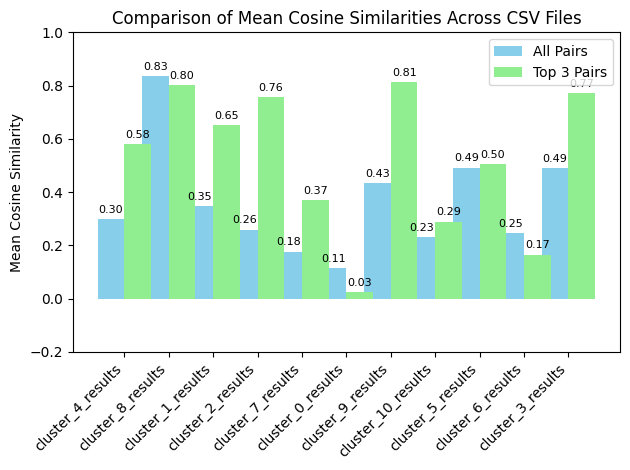

In [14]:
# Load your df_songs DataFrame
# Ensure that df_songs contains the 'track_id' column and the selected attribute columns
# df_songs = pd.read_csv('path_to_your_songs_data.csv')

# Define the attribute columns you wish to use
attribute_columns = [
    'danceability', 'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo'
]

# Standardize the attributes
scaler = StandardScaler()
df_songs[attribute_columns] = scaler.fit_transform(df_songs[attribute_columns])

# Function to compute cosine similarity between two tracks
def calculate_similarity(track_id1, track_id2, df_songs, attribute_columns):
    # Get the attributes for each track
    attributes1 = df_songs.loc[df_songs['track_id'] == track_id1, attribute_columns]
    attributes2 = df_songs.loc[df_songs['track_id'] == track_id2, attribute_columns]
    
    # Check if both tracks are found
    if not attributes1.empty and not attributes2.empty:
        # Get the attribute vectors
        vector1 = attributes1.values.flatten()
        vector2 = attributes2.values.flatten()
        # Compute cosine similarity
        similarity = cosine_similarity([vector1], [vector2])[0][0]
        return similarity
    else:
        return None  # Return None if either track is missing

# Function to compute mean cosine similarities for a CSV file
def compute_mean_cosine_similarity(file_path, df_songs, attribute_columns):
    # Load duplets and their support values
    df = pd.read_csv(file_path)
    
    # Parse the 'itemset' column safely
    duplets = []
    for _, row in df.iterrows():
        # Safely evaluate the itemset string to a tuple
        itemset = ast.literal_eval(row["itemset"])
        # Clean track IDs by stripping quotes and whitespace
        track_ids = tuple(item.strip().strip("'") for item in itemset)
        # Only consider duplets (pairs)
        if len(track_ids) == 2:
            duplets.append((track_ids, row["support"]))
    
    # If there are no duplets, return None
    if not duplets:
        return None, None
    
    # Compute cosine similarities between all duplets
    similarities = []
    for (track_id1, track_id2), support in duplets:
        sim = calculate_similarity(track_id1, track_id2, df_songs, attribute_columns)
        if sim is not None:
            similarities.append(sim)
    mean_similarity = np.mean(similarities) if similarities else None
    
    # Identify the top three duplets with the highest support
    top_three_duplets = sorted(duplets, key=lambda x: x[1], reverse=True)[:3]
    top_similarities = []
    for (track_id1, track_id2), support in top_three_duplets:
        sim = calculate_similarity(track_id1, track_id2, df_songs, attribute_columns)
        if sim is not None:
            top_similarities.append(sim)
    mean_top_similarity = np.mean(top_similarities) if top_similarities else None
    
    return mean_similarity, mean_top_similarity

# Define lists to collect results
file_names = []
mean_similarities = []
mean_top_similarities = []

# Directory containing your CSV files
input_dir = "Data/Results"

# Process each CSV file in the input directory
for file_name in os.listdir(input_dir):
    if file_name.endswith(".csv"):  # Process only CSV files
        file_path = os.path.join(input_dir, file_name)
        print(f"Processing {file_name}...")
        
        # Compute mean cosine similarities
        mean_similarity, mean_top_similarity = compute_mean_cosine_similarity(
            file_path, df_songs, attribute_columns
        )
        
        # Check if valid results are returned
        if mean_similarity is not None and mean_top_similarity is not None:
            # Collect results
            file_names.append(file_name.replace('.csv', ''))
            mean_similarities.append(mean_similarity)
            mean_top_similarities.append(mean_top_similarity)
        else:
            print(f"No valid duplets found in {file_name}. Skipping.")

# Plot the differences in means across all CSV files
if file_names:
    x = np.arange(len(file_names))  # The label locations
    width = 0.6  # The width of the bars

    plt.figure(figsize=(32, 14))
    fig, ax = plt.subplots()

    rects1 = ax.bar(x - width/2, mean_similarities, width, label='All Pairs', color='skyblue')
    rects2 = ax.bar(x + width/2, mean_top_similarities, width, label='Top 3 Pairs', color='lightgreen')

    # Add labels, title, and custom x-axis tick labels
    ax.set_ylabel('Mean Cosine Similarity')
    ax.set_title('Comparison of Mean Cosine Similarities Across CSV Files')
    ax.set_xticks(x)
    ax.set_xticklabels(file_names, rotation=45, ha='right')
    ax.set_ylim([-0.2, 1])  # Cosine similarity ranges from -1 to 1
    ax.legend()

    # Optionally, add value labels on top of the bars
    def autolabel(rects):
        """Attach a text label above each bar displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # Offset text by 3 points vertically
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")